In [33]:
%load_ext autoreload
%autoreload 2

from MPC.utils import findIC
from para_stl import paraset
import os
import pickle
from stlpy.benchmark.reach_avoid import ReachAvoid
from stlpy.benchmark.random_multitarget import RandomMultitarget
import numpy as np
from stl_planner import STL_planner
import cvxpy as cp
from solvers.OMISTL import OMISTL

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
N=10
x0 = [0.1,0.1,0,0]
vmax = 0.5
prob_params= {}
prob_params['x0'] = x0
Q = 1e-1*np.diag([0,0,1,1])   # just penalize high velocities
R = 1e-1*np.eye(2)

posmin = np.array([0.0, 0.0, -1.0, -1.0])
posmax =np.array([3.5,2.5, 1.0, 1.0])
umax = np.array([0.2, 0.2])

goal_bounds = (2.90, 3.25, 2.00, 2.25)     # (xmin, xmax, ymin, ymax)
obstacle_bounds = (1.25, 1.75, 0.20, 1.00)


scenario = ReachAvoid(goal_bounds, obstacle_bounds, N-1)
spec = scenario.GetSpecification()
spec.simplify()
spec_name= 'ReachAvoid'

# paraset(N=N,n_obs=5, Q=Q,R=R, xmin= posmin, xmax = posmax, vmax=vmax, umax =umax, spec_name=spec_name, vector=vector_mat)
# paraset(N=N,n_obs=5, Q=Q,R=R, xmin= posmin, xmax = posmax, vmax=vmax, umax =umax, spec_name=spec_name)

In [40]:
#load train/test data
# spec_name= 'ReachAvoid'

dataset_name = '{}_horizon_{}'.format(spec_name,N)

#加载设置文件地址，config = [dataset_name, prob_params, sampled_params]#
relative_path = os.getcwd()
config_fn = os.path.join(relative_path, 'config', dataset_name+'.p')

config_file = open(config_fn,'rb')
config=pickle.load(config_file)

dataset_name =  config[0]
config_file.close()#读取设置#

prob = STL_planner(config=config_fn , spec=spec)
prob.init_stl_problem()

In [47]:
prob_success, cost, solve_time,integer, vector, optvals =prob.solve_stl(prob_params,solver=cp.GUROBI,verbose=True)

                                     CVXPY                                     
                                    v1.1.20                                    
(CVXPY) Oct 16 08:17:35 PM: Your problem has 268 variables, 342 constraints, and 4 parameters.
(CVXPY) Oct 16 08:17:35 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Oct 16 08:17:35 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Oct 16 08:17:35 PM: Using cached ASA map, for faster compilation (bypassing reduction chain).
(CVXPY) Oct 16 08:17:35 PM: Finished problem compilation (took 0.000e+00 seconds).
-------------------------------------------------------------------------------
                            

In [48]:
print(prob_success)
print(solve_time)

True
0.06290435791015625


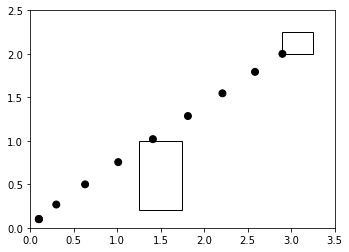

In [49]:
import matplotlib.pyplot as plt
Xopt = optvals[0]

goal_bounds = list(goal_bounds)    # (xmin, xmax, ymin, ymax)
obstacle_bounds = list(scenario.obstacle_bounds)


goal  = plt.Rectangle((goal_bounds[0], goal_bounds[2]), \
                                  goal_bounds[1]-goal_bounds[0], goal_bounds[3]-goal_bounds[2], \
                                 fc='white', ec='black')
obstacle = plt.Rectangle((obstacle_bounds[0], obstacle_bounds[2]), \
                                  obstacle_bounds[1]-obstacle_bounds[0], obstacle_bounds[3]-obstacle_bounds[2], \
                                 fc='white', ec='black')

plt.gca().add_patch(obstacle)
plt.gca().add_patch(goal)

plt.axis('scaled')


x0 = prob_params['x0']
circle = plt.Circle((x0[0],x0[1]), 0.04, fc='red',ec="red")
plt.gca().add_patch(circle)

#blue line is network prediction
# plt.plot(xg[0],xg[1],'sr')
# plt.quiver(Xopt[0,:], Xopt[1,:], Xopt[2,:], Xopt[3,:])#用箭头表示#
for jj in range(N):
    circle = plt.Circle((Xopt[0,jj],Xopt[1,jj]), 0.04, fc='black',ec="black")
    plt.gca().add_patch(circle)


posmin = np.zeros(2)

ax = plt.gca()
ax.margins(0)
ax.set(xlim=(posmin[0],posmax[0]), ylim=(posmin[1],posmax[1]))
plt.show()

In [50]:
inter_matrix = []
for i in range(len(prob.vector)):
    # print(prob.integer[i].value)
    inter_matrix.append(prob.vector[i].value)
inter_matrix

[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([0., 0., 0., 0., 1.]),
 array([0., 0., 0., 0., 1.]),
 array([0., 0., 0., 0., 1.]),
 array([0., 0., 0., 0., 1.]),
 array([0., 0., 0., 0., 1.]),
 array([0., 0., 1., 0., 0.]),
 array([0., 0., 0., 1., 0.]),
 array([0., 0., 0., 1., 0.]),
 array([0., 0., 0., 1., 0.]),
 array([0., 0., 0., 1., 0.])]

In [51]:
prob.init_pred_problem(inter_matrix)

In [52]:
prob_success, cost, solve_time, optvals =prob.solve_pred(prob_params,solver=cp.GUROBI)

                                     CVXPY                                     
                                    v1.1.20                                    
(CVXPY) Oct 16 08:17:38 PM: Your problem has 137 variables, 89 constraints, and 4 parameters.
(CVXPY) Oct 16 08:17:38 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Oct 16 08:17:38 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Oct 16 08:17:38 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Oct 16 08:17:38 PM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStuffing -> GUROBI
(CVXPY) Oct 16 08:17:38 PM: Applying reduction CvxAttr2Constr
(CVXPY) Oct 16 08:17:38 PM: Applying reduction Qp2Symbo

In [53]:
print(prob_success)
print(solve_time)

True
0.015626907348632812


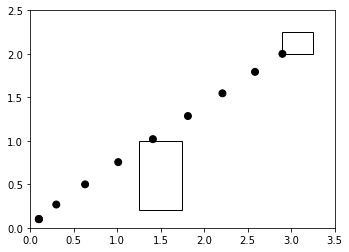

In [54]:
import matplotlib.pyplot as plt
Xopt = optvals[0]

goal_bounds = list(goal_bounds)    # (xmin, xmax, ymin, ymax)
obstacle_bounds = list(scenario.obstacle_bounds)


goal  = plt.Rectangle((goal_bounds[0], goal_bounds[2]), \
                                  goal_bounds[1]-goal_bounds[0], goal_bounds[3]-goal_bounds[2], \
                                 fc='white', ec='black')
obstacle = plt.Rectangle((obstacle_bounds[0], obstacle_bounds[2]), \
                                  obstacle_bounds[1]-obstacle_bounds[0], obstacle_bounds[3]-obstacle_bounds[2], \
                                 fc='white', ec='black')

plt.gca().add_patch(obstacle)
plt.gca().add_patch(goal)

plt.axis('scaled')


x0 = prob_params['x0']
circle = plt.Circle((x0[0],x0[1]), 0.04, fc='red',ec="red")
plt.gca().add_patch(circle)

#blue line is network prediction
# plt.plot(xg[0],xg[1],'sr')
# plt.quiver(Xopt[0,:], Xopt[1,:], Xopt[2,:], Xopt[3,:])#用箭头表示#
for jj in range(N):
    circle = plt.Circle((Xopt[0,jj],Xopt[1,jj]), 0.04, fc='black',ec="black")
    plt.gca().add_patch(circle)


posmin = np.zeros(2)

ax = plt.gca()
ax.margins(0)
ax.set(xlim=(posmin[0],posmax[0]), ylim=(posmin[1],posmax[1]))
plt.show()

In [2]:
N=25
# x0 = np.array([4.0,8.0,0,0])
x0 = np.array([2,0.5,0,0])
prob_params= {}
prob_params['x0'] = x0

vmax=1

num_obstacles = 1
num_groups = 3
targets_per_group = 2
posmin = np.array([0., 0., -1., -1.])
posmax = np.array([10., 10., 1., 1.])
max_box_size = 1.2
min_box_size = 1
box_buffer = 0.025
border_size = 0.05


scenario = RandomMultitarget(
        num_obstacles, num_groups, targets_per_group, N-1,posmin, posmax, \
                    border_size, box_buffer, min_box_size, max_box_size, seed=17)
spec = scenario.GetSpecification()
spec.simplify()

obstacles = scenario.obstacles
targets = scenario.targets

umax = np.array([0.5, 0.5])


Q = 0.001*1e-1*np.diag([0,0,1,1])   # just penalize high velocities
R = 0.001*1e-1*np.eye(2)

# paraset(N=N,n_obs=num_obstacles, Q=Q,R=R, xmin=posmin, xmax = posmax, vmax=vmax, umax =umax, spec_name= spec_name, obstacles= obstacles, targets=targets)

In [4]:
dataset_name = '{}_horizon_{}'.format(scenario.spec_name,N)

#加载设置文件地址，config = [dataset_name, prob_params, sampled_params]#
relative_path = os.getcwd()
config_fn = os.path.join(relative_path, 'config', dataset_name+'.p')

config_file = open(config_fn,'rb')
config=pickle.load(config_file)

dataset_name =  config[0]
config_file.close()#读取设置#

In [5]:
prob = STL_planner(config=config_fn , spec=spec)
prob.init_stl_problem()

In [6]:
prob_success, cost, solve_time,integer, vector, optvals =prob.solve_stl(prob_params,solver=cp.GUROBI)

                                     CVXPY                                     
                                    v1.1.20                                    
(CVXPY) Oct 16 09:00:38 PM: Your problem has 1301 variables, 1998 constraints, and 4 parameters.
(CVXPY) Oct 16 09:00:38 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Oct 16 09:00:38 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Oct 16 09:00:39 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Oct 16 09:00:39 PM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStuffing -> GUROBI
(CVXPY) Oct 16 09:00:39 PM: Applying reduction CvxAttr2Constr
(CVXPY) Oct 16 09:00:39 PM: Applying reduction Qp2Sy

In [7]:
print(prob_success)
print(solve_time)

True
9.644067764282227


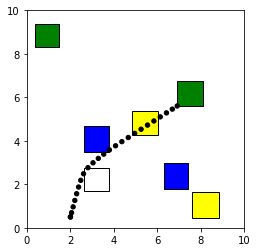

In [8]:
import matplotlib.pyplot as plt
Xopt = optvals[0]

colors = ['green','yellow','blue','grey','orange']
for i in range(len(scenario.targets)):
    color = colors[i]
    for j in range(scenario.targets_per_group):
        target_bounds = list(scenario.targets[i][j])
        targets_bounds = plt.Rectangle((target_bounds[0], target_bounds[2]), \
                                  target_bounds[1]-target_bounds[0], target_bounds[3]-target_bounds[2], \
                                 fc=color, ec='black')
        plt.gca().add_patch(targets_bounds)
        plt.axis('scaled')

for i in range(len(scenario.obstacles)):
    obstacle_bounds = list(scenario.obstacles[i])
    obstacle = plt.Rectangle((obstacle_bounds[0], obstacle_bounds[2]), \
                                  obstacle_bounds[1]-obstacle_bounds[0], obstacle_bounds[3]-obstacle_bounds[2], \
                                 fc='white', ec='black')
    plt.gca().add_patch(obstacle)

x0 = prob_params['x0']
circle = plt.Circle((x0[0],x0[1]), 0.04, fc='red',ec="red")
plt.gca().add_patch(circle)

#blue line is network prediction
# plt.plot(xg[0],xg[1],'sr')
# plt.quiver(Xopt[0,:], Xopt[1,:], Xopt[2,:], Xopt[3,:])#用箭头表示#
for jj in range(N):
    circle = plt.Circle((Xopt[0,jj],Xopt[1,jj]), 0.1, fc='black',ec="black")
    plt.gca().add_patch(circle)


posmin = np.zeros(2)

ax = plt.gca()
ax.margins(0)
ax.set(xlim=(posmin[0],posmax[0]), ylim=(posmin[1],posmax[1]))
plt.show()

In [9]:
prob.init_pred_problem(vector)

In [10]:
prob_success, cost, solve_time,optvals =prob.solve_pred(prob_params,solver=cp.GUROBI)

                                     CVXPY                                     
                                    v1.1.20                                    
(CVXPY) Oct 16 09:00:56 PM: Your problem has 342 variables, 227 constraints, and 4 parameters.
(CVXPY) Oct 16 09:00:56 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Oct 16 09:00:56 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Oct 16 09:00:56 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Oct 16 09:00:56 PM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStuffing -> GUROBI
(CVXPY) Oct 16 09:00:56 PM: Applying reduction CvxAttr2Constr
(CVXPY) Oct 16 09:00:56 PM: Applying reduction Qp2Symb

In [11]:
print(prob_success)
print(solve_time)

True
0.046871185302734375


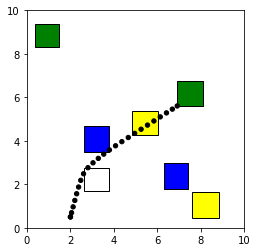

In [12]:
import matplotlib.pyplot as plt
Xopt = optvals[0]

colors = ['green','yellow','blue','grey','orange']
for i in range(len(scenario.targets)):
    color = colors[i]
    for j in range(scenario.targets_per_group):
        target_bounds = list(scenario.targets[i][j])
        targets_bounds = plt.Rectangle((target_bounds[0], target_bounds[2]), \
                                  target_bounds[1]-target_bounds[0], target_bounds[3]-target_bounds[2], \
                                 fc=color, ec='black')
        plt.gca().add_patch(targets_bounds)
        plt.axis('scaled')

for i in range(len(scenario.obstacles)):
    obstacle_bounds = list(scenario.obstacles[i])
    obstacle = plt.Rectangle((obstacle_bounds[0], obstacle_bounds[2]), \
                                  obstacle_bounds[1]-obstacle_bounds[0], obstacle_bounds[3]-obstacle_bounds[2], \
                                 fc='white', ec='black')
    plt.gca().add_patch(obstacle)

x0 = prob_params['x0']
circle = plt.Circle((x0[0],x0[1]), 0.04, fc='red',ec="red")
plt.gca().add_patch(circle)

#blue line is network prediction
# plt.plot(xg[0],xg[1],'sr')
# plt.quiver(Xopt[0,:], Xopt[1,:], Xopt[2,:], Xopt[3,:])#用箭头表示#
for jj in range(N):
    circle = plt.Circle((Xopt[0,jj],Xopt[1,jj]), 0.1, fc='black',ec="black")
    plt.gca().add_patch(circle)


posmin = np.zeros(2)

ax = plt.gca()
ax.margins(0)
ax.set(xlim=(posmin[0],posmax[0]), ylim=(posmin[1],posmax[1]))
plt.show()

## Sampling

In [13]:
N=25
# x0 = np.array([2.0,8.0,0,0])
# prob_params= {}
# prob_params['x0'] = x0

vmax=1
num_obstacles = 1
num_groups = 3
targets_per_group = 2
posmin = np.array([0., 0., -1., -1.])
posmax = np.array([10., 10., 1., 1.])
max_box_size = 1.2
min_box_size = 1
box_buffer = 0.025
border_size = 0.05

scenario = RandomMultitarget(
        num_obstacles, num_groups, targets_per_group, N-1,posmin, posmax, \
                    border_size, box_buffer, min_box_size, max_box_size, seed=17)
spec = scenario.GetSpecification()

spec.simplify()

obstacles = scenario.obstacles
targets = scenario.targets

umax = np.array([0.5, 0.5])


Q = 0.001*1e-1*np.diag([0,0,1,1])   # just penalize high velocities
R = 0.001*1e-1*np.eye(2)

# paraset(N=N,n_obs=num_obstacles, Q=Q,R=R, xmin=posmin, xmax = posmax, vmax=vmax, umax =umax, spec_name= spec_name, obstacles= obstacles, targets=targets, num_probs=10000)

In [14]:
dataset_name = '{}_horizon_{}'.format(scenario.spec_name,N)

#加载设置文件地址，config = [dataset_name, prob_params, sampled_params]#
relative_path = os.getcwd()
config_fn = os.path.join(relative_path, 'config', dataset_name+'.p')

config_file = open(config_fn,'rb')
config=pickle.load(config_file)

dataset_name =  config[0]
config_file.close()#读取设置#

prob = STL_planner(config=config_fn , spec=spec)
prob.init_stl_problem()
num_probs = config[4]
sampled_params = config[2]
params = {}
if 'x0' in sampled_params:
    params['x0'] = np.zeros((num_probs,4))
# if 'xg' in sampled_params:
#     params['xg'] = np.zeros((num_probs,4))
# if 'obstacles' in sampled_params:
#     params['obstacles'] = np.zeros((num_probs, 4, n_obs))

rec = []
for i in range(len(config[-1])):
    for j in range(len(config[-1][0])):
        rec.append(config[-1][i][j])
for i in range(len(config[-2])):
    rec.append(config[-2][i])

border_size = config[-12]
box_buffer = config[-11]
min_box_size = config[-10]
max_box_size = config[-9]
posmin = config[-8]
posmax = config[-7]
velmin = config[-6]
velmax = config[-5]
# num_probs =config[4]

X = np.zeros((num_probs, 4, N));
U = np.zeros((num_probs, 2, N))
Y = np.zeros((num_probs, 6, N)).astype(int)

costs = np.zeros(num_probs)
solve_times = np.zeros(num_probs)

integer_data = []
for i in range(num_probs):
    integer_data.append(0)

vector_data = []
for i in range(num_probs):
    vector_data.append(0)

In [18]:
from tqdm import tqdm
params = {}

if 'x0' in sampled_params:
    params['x0'] = np.zeros((num_probs,4))
# if 'xg' in sampled_params:
#     params['xg'] = np.zeros((num_probs,2*n))
# if 'obstacles' in sampled_params:
#     params['obstacles'] = np.zeros((num_probs, 4, n_obs))

for ii in tqdm(range(num_probs)):
    x0 = findIC(rec, posmin[:2], posmax[:2], velmin, velmax)
    x0[2:]=0
    # params['obstacles'][ii,:] = np.reshape(np.concatenate(obstacles, axis=0), (n_obs,4)).T
    p_dict = {}
    params['x0'][ii,:] = x0
    # xg= findIC(obstacles, posmin, posmax, velmin, velmax)
    # params['xg'][ii,:] = xg

    p_dict['x0'] = params['x0'][ii,:]
    # p_dict['xg'] = params['xg'][ii,:]
    # p_dict['obstacles'] = params['obstacles'][ii,:]

    prob_success = False
    try:
        # with time_limit(20):
        prob_success, cost, solve_time, integer, vector, optvals = prob.solve_stl(p_dict, solver=cp.GUROBI)
    except (KeyboardInterrupt, SystemExit):
        raise
    except:
        print('solver failed at '.format(ii))

    if prob_success:
        vector_data[ii] = vector
        integer_data[ii] = integer
        costs[ii] = cost; solve_times[ii] = solve_time
        X[ii,:,:], U[ii,:,:], Y[ii,:,:]= optvals
        ii += 1

num_train = int(num_probs*0.9)
arr = np.arange(num_probs)
np.random.shuffle(arr)

if 'x0' in sampled_params:
    params['x0'] = params['x0'][arr]

costs = costs[arr]
solve_times = solve_times[arr]


X = X[arr]
U = U[arr]
Y = Y[arr]

integer_data = np.array(integer_data)
integer_data = integer_data[arr]
vector_data = np.array(vector_data)
vector_data = vector_data[arr]

train_params = {}; test_params = {}
if 'x0' in sampled_params:
    train_params['x0'] = params['x0'][:num_train,:]
    test_params['x0'] = params['x0'][num_train:,:]
# if 'obstacles' in sampled_params:
#     train_params['obstacles'] = params['obstacles'][:num_train,:]
#     test_params['obstacles'] = params['obstacles'][num_train:,:]
# if 'xg' in sampled_params:
#     train_params['xg'] = params['xg'][:num_train,:]
#     test_params['xg'] = params['xg'][num_train:,:]

train_data = [train_params]
train_data += [X[:num_train,:,:], U[:num_train,:,:], Y[:num_train,:,:]]
train_data += [costs[:num_train], solve_times[:num_train]]
train_data += [vector_data[:num_train], integer_data[:num_train]]

test_data = [test_params]
test_data += [X[num_train:,:,:], U[num_train:,:,:], Y[num_train:,:,:]]
test_data += [costs[num_train:], solve_times[num_train:]]
test_data += [vector_data[num_train:], integer_data[num_train:]]

train_fn = 'train_horizon_{}_{}.p'.format(N,spec_name)
train_fn = os.path.join(relative_path, 'data', dataset_name, train_fn)
test_fn = 'test_horizon_{}_{}.p'.format(N,spec_name)
test_fn = os.path.join(relative_path, 'data', dataset_name, test_fn)


train_file = open(train_fn,'wb')
pickle.dump(train_data,train_file); train_file.close()

test_file = open(test_fn, 'wb')
pickle.dump(test_data,test_file); test_file.close()

  0%|          | 0/10000 [00:02<?, ?it/s]


KeyboardInterrupt: 

In [15]:
relative_path = os.getcwd()
train_fn = 'train_horizon_{}.p'.format(N)
train_fn = os.path.join(relative_path, 'data', dataset_name, train_fn)
train_file = open(train_fn,'rb')
# train_file = open(dataset_fn+'/train.p','rb')
train_data = pickle.load(train_file)

In [16]:
system = scenario.spec_name
prob_features = ['x0']
stl_obj = OMISTL(system, prob, prob_features)
stl_obj.construct_stl_strategies(train_data,4)
print(stl_obj.n_strategies)

3271


In [27]:
def train_horizon_stl(N, spec, device_id=0):
    dataset_name = '{}_horizon_{}'.format(scenario.spec_name,N)
    relative_path = os.getcwd()
    config_fn = os.path.join(relative_path, 'config', dataset_name+'.p')
    config_file = open(config_fn,'rb')
    config =  pickle.load(config_file)
    dataset_name = config[0]; config_file.close()

    train_fn = 'train_horizon_{}_{}.p'.format(N,spec_name)
    train_fn = os.path.join(relative_path, 'data', dataset_name, train_fn)
    test_fn = 'test_horizon_{}_{}.p'.format(N,spec_name)
    test_fn = os.path.join(relative_path, 'data', dataset_name, test_fn)

    train_file = open(train_fn,'rb')
    train_data = pickle.load(train_file); train_file.close()

    test_file = open(test_fn,'rb')
    test_data = pickle.load(test_file)

    test_file.close()

    system = scenario.spec_name
    prob_features = ['x0']

    prob = STL_planner(config=config_fn , spec=spec)
    Network = OMISTL(system, prob, prob_features)

    Network.construct_stl_strategies(train_data, 4)

    print('Number of strategies for horizon {}: {}'.format(N, Network.n_strategies))

    Network.setup_network(device_id=device_id)
    Network.training_params['TRAINING_ITERATIONS'] =500
    Network.train(train_data=train_data, verbose=True)

In [28]:
train_horizon_stl(25,spec)

Number of strategies for horizon 25: 3271
Done with epoch 0 in 0.7187447547912598s
Done with epoch 1 in 0.640627384185791s
Done with epoch 2 in 0.6094915866851807s
Done with epoch 3 in 0.6093406677246094s
Done with epoch 4 in 0.6250641345977783s
Done with epoch 5 in 0.6094105243682861s
Done with epoch 6 in 0.562462568283081s
loss:   4.344592094421387,   acc:  0.15625
Done with epoch 7 in 0.5470478534698486s
Done with epoch 8 in 0.5625121593475342s
Done with epoch 9 in 0.5468649864196777s
Done with epoch 10 in 0.546907901763916s
Done with epoch 11 in 0.5314681529998779s
Done with epoch 12 in 0.5937573909759521s
Done with epoch 13 in 0.5937480926513672s
loss:   3.2883923053741455,   acc:  0.15625
Done with epoch 14 in 0.5782649517059326s
Done with epoch 15 in 0.5312552452087402s
Done with epoch 16 in 0.5469188690185547s
Done with epoch 17 in 0.5312502384185791s
Done with epoch 18 in 0.5470218658447266s
Done with epoch 19 in 0.5312497615814209s
Done with epoch 20 in 0.5313856601715088s
lo

In [17]:
fn_saved = '../../models/{}_horizon_{}.pt'.format(scenario.spec_name,str(N))
prob = STL_planner(config=config_fn , spec=spec)
stl_obj = OMISTL(system, prob, prob_features)
stl_obj.construct_stl_strategies(train_data,4)
stl_obj.setup_network()
stl_obj.load_network(fn_saved)
stl_obj.model

Loading presaved classifier model from ../../models/RandomMultitarget_horizon_25.pt


FFNet(
  (activation): ReLU()
  (layers): ModuleList(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=128, bias=True)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): Linear(in_features=128, out_features=3271, bias=True)
  )
)

In [18]:
prob.init_stl_problem()
p_dict = {}
p_dict['x0'] = [5,0.5,0,0]
prob_success, cost, solve_time, sos1 ,vector, optvals_ori =prob.solve_stl(p_dict,solver=cp.GUROBI)

                                     CVXPY                                     
                                    v1.1.20                                    
(CVXPY) Oct 16 09:01:56 PM: Your problem has 1301 variables, 1998 constraints, and 4 parameters.
(CVXPY) Oct 16 09:01:57 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Oct 16 09:01:57 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Oct 16 09:01:57 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Oct 16 09:01:57 PM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStuffing -> GUROBI
(CVXPY) Oct 16 09:01:57 PM: Applying reduction CvxAttr2Constr
(CVXPY) Oct 16 09:01:57 PM: Applying reduction Qp2Sy

In [19]:
print('Original problem has 1998 constraints，1301 variables which contains 93 integer variables')
print('Solving original problem with STL tree encoding spends : ' + str(solve_time)+ 's')

Original problem has 1998 constraints，1301 variables which contains 93 integer variables
Solving original problem with STL tree encoding spends : 1.9691295623779297s


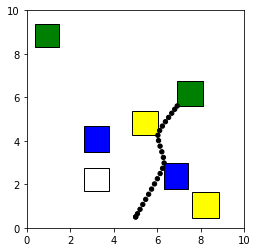

In [20]:
import matplotlib.pyplot as plt
Xopt = optvals_ori[0]

colors = ['green','yellow','blue','grey','orange']
for i in range(len(scenario.targets)):
    color = colors[i]
    for j in range(scenario.targets_per_group):
        target_bounds = list(scenario.targets[i][j])
        targets_bounds = plt.Rectangle((target_bounds[0], target_bounds[2]), \
                                  target_bounds[1]-target_bounds[0], target_bounds[3]-target_bounds[2], \
                                 fc=color, ec='black')
        plt.gca().add_patch(targets_bounds)
        plt.axis('scaled')

for i in range(len(scenario.obstacles)):
    obstacle_bounds = list(scenario.obstacles[i])
    obstacle = plt.Rectangle((obstacle_bounds[0], obstacle_bounds[2]), \
                                  obstacle_bounds[1]-obstacle_bounds[0], obstacle_bounds[3]-obstacle_bounds[2], \
                                 fc='white', ec='black')
    plt.gca().add_patch(obstacle)

x0 = p_dict['x0']
circle = plt.Circle((x0[0],x0[1]), 0.04, fc='red',ec="red")
plt.gca().add_patch(circle)

for jj in range(N):
    circle = plt.Circle((Xopt[0,jj],Xopt[1,jj]), 0.1, fc='black',ec="black")
    plt.gca().add_patch(circle)

posmin = np.zeros(2)
ax = plt.gca()
ax.margins(0)
ax.set(xlim=(posmin[0],posmax[0]), ylim=(posmin[1],posmax[1]))
plt.show()

In [38]:
prob.init_stl_problem(True)
prob_success, cost, solve_time, sos1 ,vector, optvals_ori =prob.solve_stl(p_dict,solver=cp.GUROBI,verbose=False)

In [22]:
print('original problem has 1506 constraints，1180 variables which contains 250 integer variables')
print('solving original problem using standard STL encoding spends : ' + str(solve_time)+ 's')

original problem has 1506 constraints，1180 variables which contains 250 integer variables
solving original problem using standard STL encoding spends : 1.3941707611083984s


In [39]:
prob_success, cost, solve_time, solution, optvals_ML = stl_obj.Predict(p_dict,solver=cp.GUROBI,max_evals=16,verbose=False)

prediction is success:True


In [40]:
print('reduced problem has 342 constraints，227 variables which contains 0 integer variables')
print('solving reduced ML problem using STL tree spends : ' + str(solve_time)+ 's')

reduced problem has 342 constraints，227 variables which contains 0 integer variables
solving reduced ML problem using STL tree spends : 0.015625s


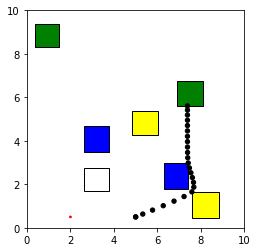

In [37]:
import matplotlib.pyplot as plt
Xopt = optvals_ML[0]

colors = ['green','yellow','blue','grey','orange']
for i in range(len(scenario.targets)):
    color = colors[i]
    for j in range(scenario.targets_per_group):
        target_bounds = list(scenario.targets[i][j])
        targets_bounds = plt.Rectangle((target_bounds[0], target_bounds[2]), \
                                  target_bounds[1]-target_bounds[0], target_bounds[3]-target_bounds[2], \
                                 fc=color, ec='black')
        plt.gca().add_patch(targets_bounds)
        plt.axis('scaled')

for i in range(len(scenario.obstacles)):
    obstacle_bounds = list(scenario.obstacles[i])
    obstacle = plt.Rectangle((obstacle_bounds[0], obstacle_bounds[2]), \
                                  obstacle_bounds[1]-obstacle_bounds[0], obstacle_bounds[3]-obstacle_bounds[2], \
                                 fc='white', ec='black')
    plt.gca().add_patch(obstacle)

x0 = prob_params['x0']
circle = plt.Circle((x0[0],x0[1]), 0.04, fc='red',ec="red")
plt.gca().add_patch(circle)

#blue line is network prediction
# plt.plot(xg[0],xg[1],'sr')
# plt.quiver(Xopt[0,:], Xopt[1,:], Xopt[2,:], Xopt[3,:])#用箭头表示#
for jj in range(N):
    circle = plt.Circle((Xopt[0,jj],Xopt[1,jj]), 0.1, fc='black',ec="black")
    plt.gca().add_patch(circle)


posmin = np.zeros(2)

ax = plt.gca()
ax.margins(0)
ax.set(xlim=(posmin[0],posmax[0]), ylim=(posmin[1],posmax[1]))
plt.show()